# Spectrogram Plotting
This example script plots a waveform / spectrogram and a corresponding segmentation

Note: this example notebook does the plotting directly in matplotlib and has a minimum of other dependencies
+ librosa is used for the spectrogram computations
+ soundfile is used for importing audiofiles
+ examples are given for importing data from url resources
+ for compliance testing between librosa, Kaldi, SPRAAK and torchaudio see spectrogram-librosa-torch.ipynb

## First do all the imports


In [1]:
%matplotlib inline
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML

import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import librosa as librosa
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
try:
  import soundfile as sf
except:
  ! pip -q install soundfile
  import soundfile as sf

## Define spectrogram routines and plotting
- spg = spectrogram(y)
    + returns mel spectrogram by default, 
    + help(spectrogram) for full options
- spg_plot(spg)
    + plots a spectrogram with optional waveform and segmentations
    + help(spg_plot) for full options

In [23]:
# a few utilities
# routine for reading audio from different inputs
def read_audio_from_url(url):
  fp = io.BytesIO(urlopen(url).read())
  data, sr = sf.read(fp,dtype='float32')
  return(data,sr)

# time to index converstions;  inputs can be scalars, lists or numpy arrays  outputs are always numpy arrays
def t2indx(t,sr):
  return (np.array(t).astype(float)*float(sr)+0.5).astype(int)
def indx2t(i,sr):
  return np.array(i).astype(float)/float(sr)

#scale=10.0/math.log(10)
DB_EPSILON_KALDI = -69.23689    # scale*math.log(1.19209290e-7)  default flooring applied in KALDI
EPSILON_FLOAT = 1.19209290e-7
    
def spectrogram(y,samplerate=16000,frame_shift=10.,frame_length=30.,preemp=0.97,n_fft=512,window='hamm',output='dB',n_mels=None):
    '''
    spectrogram is a wrapper making use of the librosa() library with some adjustments:
        - frame positioning 
            centered at: k*n_shift + n_shift/2
            #frames:  n_samples // n_shift   , first and last frame partially artificial
        - edge processing (mirroring of input signal) similar to Kaldi / SPRAAK
        - pre-emphasis applied after edge processing

    required arguments:
      y       waveform data (numpy array) 

    optional arguments:
      samplerate   sample rate in Hz, default=16000
      frame_shift  frame shift in msecs, default= 10.0 msecs
      frame_length frame length in msecs, default= 30.0 msecs
      preemp       preemphasis coefficient, default=0.95
      window       window type, default='hamm'
      n_mels       number of mel channels, default=80
      n_fft        number of fft coefficients, default=512
      n_mels         number of mel coefficients, default=None
      output       output scale, default='dB', options['dB','power']
      (amin         flooring applied to power before conversion to dB (default= KALDI EPSILON)  )   

    output:
      spectrogram (in dB)
         
    '''
    n_shift = int(float(sr)*frame_shift/1000.0)
    n_length = int(float(sr)*frame_length/1000.0)
    
    # extend the edges by mirroring
    ii = n_shift//2
    n_pad = n_fft//2
    z=np.concatenate((y[0:n_pad][::-1],y,y[:-n_pad-1:-1]))
    z[0]=(1.-preemp)*y[0]
    z[1:]= z[1:] - preemp*z[0:-1]
    y_pre = z[ii:len(z)-ii]
   
    spg_stft = librosa.stft(y_pre,n_fft=n_fft,hop_length=n_shift,win_length=n_length,window=window,center=False)
    spg_power = np.abs(spg_stft)**2
    
    if n_mels == None:   spg = spg_power
    else:                spg = librosa.feature.melspectrogram(S=spg_power,n_mels=n_mels,sr=samplerate) 
        
    if output== 'dB':    return(librosa.power_to_db(spg,amin=EPSILON_FLOAT))
    else:                return(spg)

In [24]:
# spectrogram plotting routine with optionally:
#   -- waveform 
#   -- up to 2 segmentations in segmentation panel at the bottom
#   -- optionally a pseudo aligned word transcription in the wav panel
#
def plot_spg(spg=None,wav=None,seg=None,txt=None,figsize=(12,8),spg_scale=2,sr=16000,n_shift=160,tlim=None):
    '''plot_spg(): Spectrogram plotting routine
            screen will be built of 3 parts
            TOP:     waveform data (optional) + optional word transcriptions
            MIDDLE:  spectrogram data (at least one required)
            BOTTOM:  segmentations (optional)
    
        fig         figure handle for the plot
        spg         spectrogram (list or singleton) data (required), numpy array [n_param, n_fr] 
        wav         waveform data (optional)
        seg         segmentation (list, singleton or none) plotted in segmentation window at the bottom
                    should be passed as DataFrame, optional
        txt         full segment transcript to be printed in waveform axis
        figsize     figure size (default = (12,8))
        spg_scale   vertical scale of spectrogram wrt wav or seg  (default=2)
        sr          sampling rate (default=16000)
        n_shift     frame shift in samples, or equivalently the width of non-overlapping frames
                      this is used for synchronisation between waveform and spectrogram/segmentations
        
        tlim     


        Notes on alignment:
          The caller of this routine is responsible for the proper alignment between sample stream and frame stream
          (see spectrogram() routine).  By default the full sample stream is plotted.

          spg(n_param,n_fr)    
                  x-range   0 ... nfr-1
                  x-view  [-0.5 , nfr-0.5 ]    extends with +- 0.5
          wavdata(n_samples)
                  x-range   0 ... wavdata
                  x-view    -n_shift/2   nfr*n-shift - n_shift/2   (all converted to timescale)
        '''

    if spg is None:
        print("plot_spg(): You must at least provide a spectrogram")
        return
    if type(spg) is not list: spg = [ spg ]
    nspg = len(spg)
    (n_param,n_fr) = spg[0].shape
    
    if seg is None:
        nseg = 0
    else:
        if type(seg) is not list: seg = [seg]
        nseg = len(seg)
        SegPlot = True       

    WavPlot = False if wav is None   else True
    TxtPlot = False if txt is None   else True
    nwav = 1        if WavPlot       else 0
    
    # make an axes grid for nwav waveform's, nspg spectrogram's, nseg segmentation's
    base_height = 1.0/(nwav+nseg/2.0+nspg*spg_scale)
    nrows = nwav+nspg+nseg
    heights = [base_height]*nrows
    for i in range(0,nspg): heights[nwav+i] = base_height*spg_scale
    for i in range(0,nseg): heights[nwav+nspg+i] = base_height/2.0
    fig = plt.figure(figsize=figsize,clear=True,constrained_layout=True)
    gs = fig.add_gridspec(nrows=nrows,ncols=1,height_ratios=heights)
    
    # frame-2-time synchronization on basis of n_fr frames in spectrogram and n_shift
    #    by default it extends the view at the edges by  1/2 nshift samples
    indxlimits = np.array([-n_shift/2, n_fr*n_shift-n_shift/2])
    tlimits = indx2t(indxlimits,sr)  

    # add waverform plot
    if WavPlot:
        ax = fig.add_subplot(gs[0,0])
        n_samples = len(wav)
        # if n_samples <= ((n_fr-1) * n_shift):
        #    print("plot_spg() WARNING: waveform too short for spectrogram: %d <= (%d-1) x %d" %
        #          (n_samples, n_fr,n_shift))
        wavtime = np.linspace(0.0, indx2t(n_samples,sr), n_samples)
        ax.plot(wavtime,wav)
        wmax = 1.2 * max(abs(wav))
        ax.set_ylim(-wmax,wmax)
        fshift = indx2t(n_shift,sr)
        ax.set_xlim(tlimits)

        ax.tick_params(axis='x',labeltop=True,top=True,labelbottom=False,bottom=False)
        if TxtPlot:
            ax.text(tlimits[1]/2.,0.66*wmax,txt,fontsize=16,horizontalalignment='center')  

    # add spectrograms
    for i in range(0,nspg):
        ax = fig.add_subplot(gs[nwav+i,0])
        ax.imshow(spg[i],cmap='jet',aspect='auto',origin='lower')
        ax.tick_params(axis='x',labelrotation=0.0,labelbottom=False,bottom=True)        
        if (i == nspg-1) & (nseg==0):
            ax.tick_params(axis='x',labelbottom=True)

    # add segmentations
    for i in range(0,nseg):
        ax = fig.add_subplot(gs[nwav+nspg+i,0])
        plot_seg(ax,seg[i],xlim=tlimits,ytxt=0.5,linestyle='dashed',fontsize=10)
        if i != nseg-1:
            ax.tick_params(axis='x',labelbottom=False)

#        plot_seg(ax,seg1,ymin=0.5,ymax=1.0,ytxt=0.75,linestyle='dashed',fontsize=10)
#        plot_seg(ax_seg,seg2,ymin=0.,ymax=0.5,ytxt=0.25,linecolor='r')
        
    return(fig)

# routine for plotting the segmentations   
def plot_seg(ax,df,xlim=[0.,1.],ytxt=0.5,linestyle='solid',linecolor='k',fontsize=14,Vlines=True):
    ''' plot_seg(): plots a segmentation to an axis

    ax:   axis
    df:   dataframe with segment data

    xlim:       X-axis range (default: [0 1])
    [ ymin, ymax: Y-axis range (default: [0 1]) ]
    ytxt        height at which to write out the segmentation (default= 0.5)
    Vlines      flag for plotting segmentation lines (default=True)
    linestyle   default='solid'
    linecolor   default='k'
    fontsize    default=14
    ''' 

    # First plot a dummy axis to avoid matplotlib going wild
    ax.imshow(np.zeros((1,1)),aspect='auto',cmap='Greys',vmin=0.,vmax=1) 
    for iseg in range(0,len(df)):
        i1= df['t0'][iseg]
        i2= df['t1'][iseg]
        txt = df['seg'][iseg]
        if(Vlines):
            ax.vlines([i1,i2],0.,1.,linestyles=linestyle,colors=linecolor)
        xtxt = float(i1+(i2-i1)/2.0)
        ax.text(xtxt,ytxt,txt,fontsize=fontsize,horizontalalignment='center')  
        
    ax.tick_params(axis='y',labelleft=False,left=False)
    ax.set_ylim([0.,1.])
    ax.set_xlim(xlim)

## Import data
- sampled data, reads
  + wavdata  (numpy array)
  + sr       (int)
- different levels of segmentation  In the example code 
  + TIMIT style segmentations are being read 
  + sample based segmentations are converted time based segmentations
  + segmentations are stored in a dataframe with columns ['t0','t1','seg']

In [25]:
dir='https://raw.githubusercontent.com/compi1234/spchlab/master/data/'
wavfile = "timit/si1027.wav" #@param {type:"string"}
sent_segmentation = "timit/si1027.txt" #@param {type:"string"}
word_segmentation = "timit/si1027.wrd" #@param {type:"string"}
phone_segmentation = "timit/si1027.phn" #@param {type:"string"}
word_segmentation = "timit/si1027.wrd" #@param {type:"string"}
phone_mapping = "timit/phones-61-48-39.txt" #@param {type:"string"}

# read the datafiles
wavdata, sr = read_audio_from_url(dir+wavfile)
transcript = io.StringIO(urlopen(dir+sent_segmentation).read().decode('utf-8')).readline().strip().split(None,2)[2]
segwrd = pd.read_csv(dir+word_segmentation,delim_whitespace=True,names=['t0','t1','seg'])
segphn = pd.read_csv(dir+phone_segmentation,delim_whitespace=True,names=['t0','t1','seg'])

# convert sample based segmentations to time based segmentations
segphn['t0']=indx2t(segphn['t0'],sr)
segphn['t1']=indx2t(segphn['t1'],sr)
segwrd['t0']=indx2t(segwrd['t0'],sr)
segwrd['t1']=indx2t(segwrd['t1'],sr)

# convert TIMIT61 to TIMIT39
# this routine is not great as it simply maps closures to silence instead to combining
phone_tbl = pd.read_csv(dir+phone_mapping,delim_whitespace=True,names=['T61','T48','T39'])
map61_39 = dict(zip(phone_tbl['T61'],phone_tbl['T39']))
segphn39 = segphn.replace({"seg": map61_39})

## Compute Spectrograms and Plot them
#### Basic Waveform + Spectrogram

Text(0, 0.5, 'Frequency Coefficient')

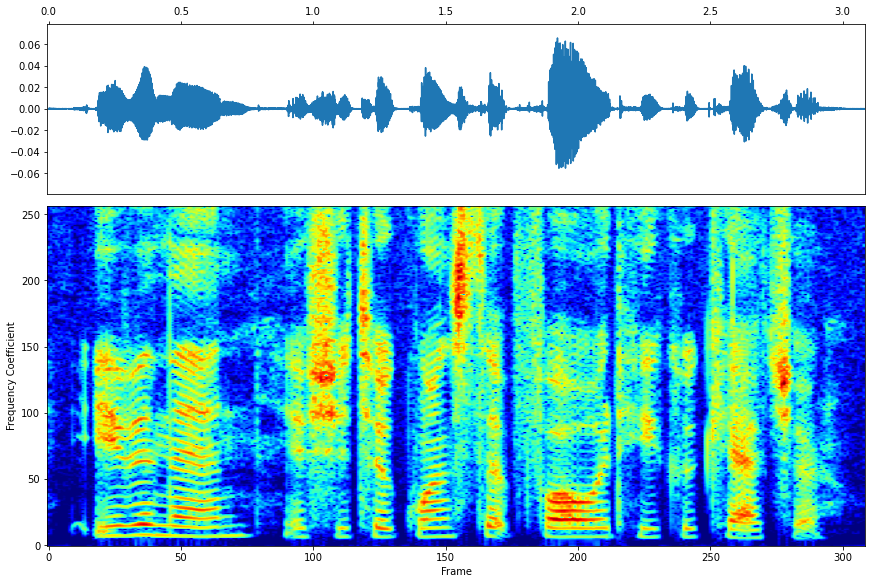

In [41]:
spg = spectrogram(wavdata,samplerate=sr)
fig=plot_spg(spg=[spg], wav=wavdata)
ax = fig.get_axes()
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Frequency Coefficient')

#### Multiple Spectrograms and Segmentations

Text(0, 0.5, 'mel fbank(24)')

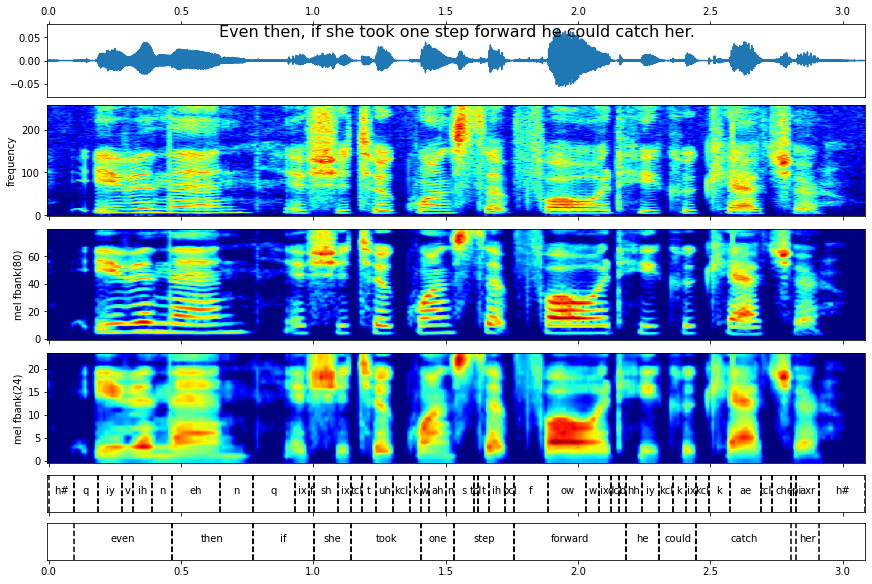

In [40]:
# compute a standard spectrogram and a 80 and 24 channel mel filterbank
spg = spectrogram(wavdata,samplerate=sr,n_mels=None)
spg80 = spectrogram(wavdata,samplerate=sr,n_mels=80)
spg24 = spectrogram(wavdata,samplerate=sr,n_mels=24)
# display audio button and the spectrograms ; add additional lables
display(Audio(data=wavdata,rate=sr))
fig=plot_spg(spg=[spg,spg80,spg24], wav=wavdata, seg=[segphn,segwrd],txt=transcript,figsize=(12,8),spg_scale=1.5)
ax = fig.get_axes()
ax[1].set_ylabel('frequency')
ax[2].set_ylabel('mel fbank(80)')
ax[3].set_ylabel('mel fbank(24)')